# Authors:
- Paweł Świątek 160301
- Jędrzej Szmidt 160292

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction (showing which part of which series is responsible for a defect)
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False  True]


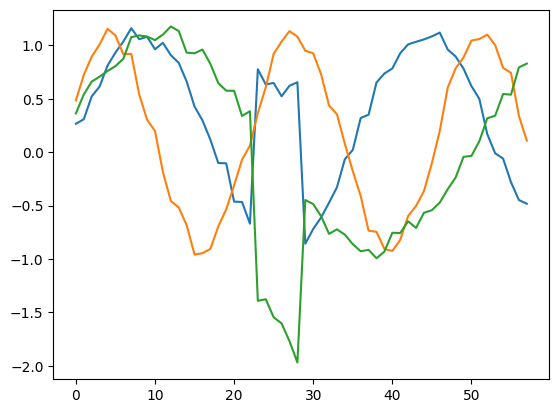

[False False False  True  True]


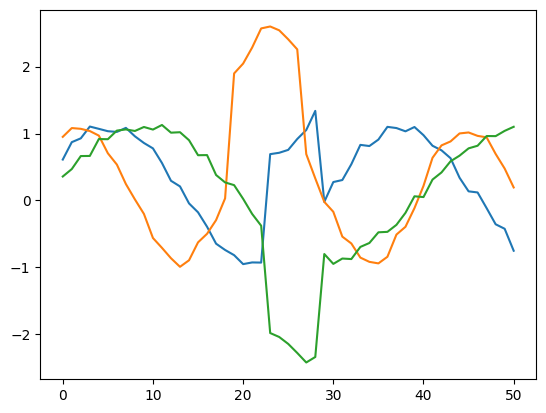

[False False False False False]


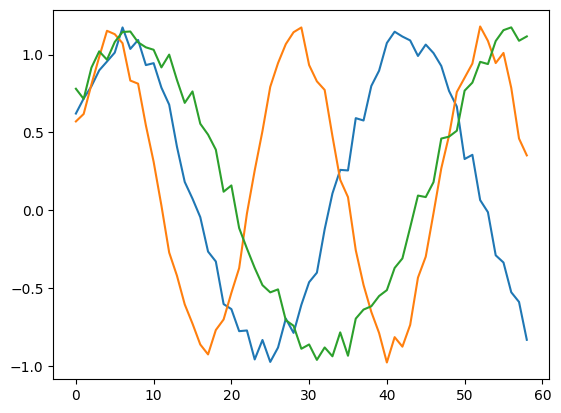

[ True False False False  True]


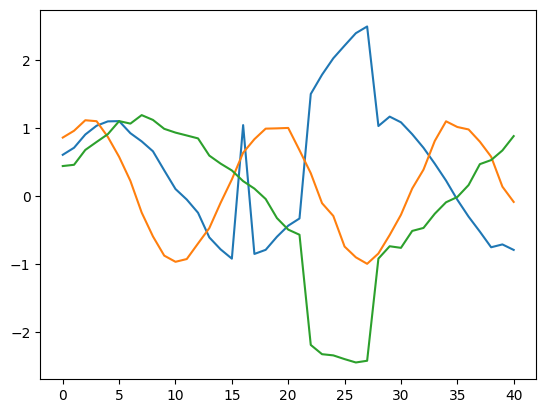

[False  True False False False]


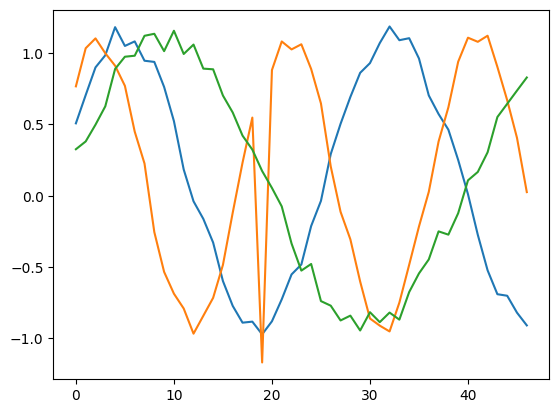

In [6]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

# Our solution

Let's make sure we are using cuda version of pytorch.

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Preperation of data

Let's create padded tensors from the given data. We want for everything to be uniform.

In [8]:
from torch.nn.utils.rnn import pad_sequence

# xl is a list of [seq_len, feat] arrays
xl_tensors = [torch.tensor(x, dtype=torch.float32) for x in xl]
xl_padded = pad_sequence(xl_tensors, batch_first=True)  # (N, T, F)

yl_tensor = torch.tensor(yl, dtype=torch.float32)

C:\Users\pawel\AppData\Local\Temp\ipykernel_17412\1147183932.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  yl_tensor = torch.tensor(yl, dtype=torch.float32)


Now we devide data into train, validation and test sets.

In [9]:
n = len(xl_padded)

train_frac, val_frac = 0.8, 0.1
train_size = int(n * train_frac)
val_size = int(n * val_frac)

x_train = xl_padded[:train_size]
y_train = yl_tensor[:train_size]

x_val = xl_padded[train_size:train_size + val_size]
y_val = yl_tensor[train_size:train_size + val_size]

x_test = xl_padded[train_size + val_size:]
y_test = yl_tensor[train_size + val_size:]

print(f"Train size: {len(x_train)}, Val size: {len(x_val)}, Test size: {len(x_test)}")


Train size: 40000, Val size: 5000, Test size: 5000


We create data loaders for those sets.

In [10]:
batch_size = 64

train_loader = DataLoader(
    TensorDataset(x_train, y_train),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(x_val, y_val),
    batch_size=batch_size
)

test_loader = DataLoader(
    TensorDataset(x_test, y_test),
    batch_size=batch_size
)

## RNN Model

We are defining our simple RNN classifier. It has two Long Short Term Memory(LSTM) layers and one linear with sigmoid at the end.

In [11]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden1=64, hidden2=32, num_classes=5):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden1, hidden2, batch_first=True)
        self.fc = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]          # last timestep
        return torch.sigmoid(self.fc(x))


We are creating model for our problem. We are also making sure that we will be using cuda (I don't want to wait longer then it's neccesary).

In [12]:
seqLen = x_train.shape[1]
featNum = x_train.shape[2]

model = RNNClassifier(featNum).to(device)
print(next(model.parameters()).device)

cuda:0


We will be using Binary Cross-Entropy loss function, because it's best pick for binary classification like in our problem. I will be using Adam optimizer because I use it most often and it's overall good.

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float("inf")
patience = 7
counter = 0

## Training model

I already did that, but if you want to retrain it yourself just change `retrain` variable to `True` and rerun the code.

In [14]:
epochs = 50

retrain = False

if retrain:
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                val_loss += criterion(model(xb), yb).item()

        print(f"Epoch {epoch+1}: "
            f"Train {train_loss:.4f}, Val {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "RNN_model.pt")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

Since model was already trained let's load it from the file.

In [15]:
model.load_state_dict(torch.load("RNN_model.pt"))
model.eval()

C:\Users\pawel\AppData\Local\Temp\ipykernel_17412\3090887558.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("RNN_model.pt"))


RNNClassifier(
  (lstm1): LSTM(3, 64, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Now, we should check how good our predictions are.

In [16]:
y_pred = []
y_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred.append(preds)
        y_true.append(yb.numpy())

y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)
print("Accuracy: ", np.mean(y_pred == y_true))

Accuracy:  0.0


Something is wrong, let's check it

In [17]:
for i, j in zip(y_pred[:5], y_true[:5]):
    print("Predicted:", i, "True:", j)

Predicted: [9.9949551e-01 2.6868898e-04 4.9002361e-03 3.0973667e-04 9.9998224e-01] True: [1. 0. 0. 0. 1.]
Predicted: [9.2304865e-05 9.9979848e-01 1.9824302e-03 1.4255292e-04 9.9998009e-01] True: [0. 1. 0. 0. 1.]
Predicted: [2.1810730e-03 2.8224953e-04 3.3736244e-02 5.3899235e-04 9.9998403e-01] True: [0. 0. 0. 0. 1.]
Predicted: [1.6333647e-04 3.4248584e-04 4.1897534e-04 3.2431730e-05 1.8001633e-04] True: [0. 0. 0. 0. 0.]
Predicted: [9.9959022e-01 2.2096105e-04 7.3634200e-03 3.8544688e-04 9.9997926e-01] True: [1. 0. 0. 0. 1.]


Now we can see what we did wrong. In order to measure the actual accuracy we need to perform one last step - binarize predictions.

In [18]:
y_pred_bin = (y_pred > 0.5).astype(int)
accuracy = np.mean(y_pred_bin == y_true)

print("Binarized Accuracy:", accuracy)
for i in range(5):
    prec = precision_score(y_true[:, i], y_pred_bin[:, i])
    rec = recall_score(y_true[:, i], y_pred_bin[:, i])
    print(f"Class {i}: Precision: {prec:.4f}, Recall: {rec:.4f}")

Binarized Accuracy: 0.99832
Class 0: Precision: 1.0000, Recall: 0.9992
Class 1: Precision: 0.9968, Recall: 0.9968
Class 2: Precision: 0.9879, Recall: 0.9855
Class 3: Precision: 1.0000, Recall: 1.0000
Class 4: Precision: 1.0000, Recall: 1.0000


An accuracy of 0.99832 indicates that the model correctly predicted the presence or absence of defects in 99.832% of test cases after binarizing the probabilities with a threshold of 0.5. This suggests the model performs exceptionally well on the test data and implies that there is no need to perfrom futher tests on different architectures, parameters etc.

## Example

Below there is short analysis of a one particular reading of index `idx`.

In [19]:
idx = 42

print("Raw probabilities:")
print(y_pred[idx])

print("\nBinarized:")
print(y_pred_bin[idx])

print("\nGround truth:")
print(y_true[idx])


Raw probabilities:
[5.21254377e-04 4.77654321e-05 2.33112350e-02 1.10066576e-04
 9.99990463e-01]

Binarized:
[0 0 0 0 1]

Ground truth:
[0. 0. 0. 0. 1.]


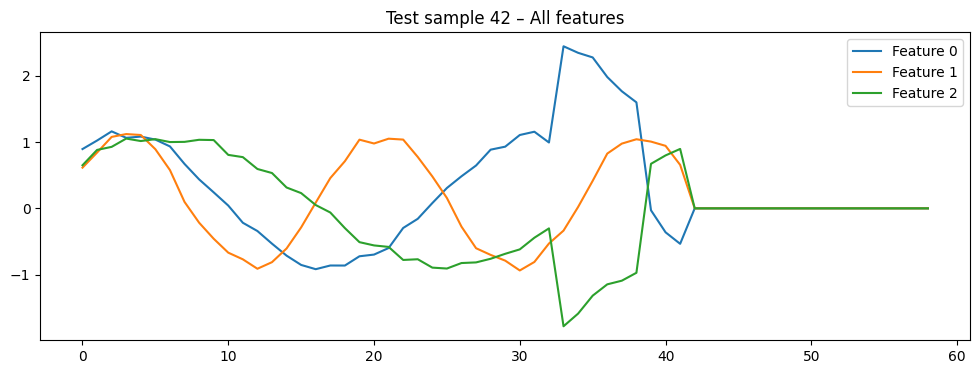

In [20]:
plt.figure(figsize=(12, 4))
for f in range(x_test.shape[2]):
    plt.plot(x_test[idx, :, f], label=f"Feature {f}")
plt.legend()
plt.title("Test sample {} – All features".format(idx))
plt.show()

If you see straight line at the end of the plot, don't worry, it's just padding we added earlier.

## Example of wrong classification

In [21]:
wrong_indices = np.where(np.any(y_pred_bin != y_true, axis=1))[0]
print(f"Number of wrongly classified samples: {len(wrong_indices)}")

Number of wrongly classified samples: 41


In [22]:
idx = wrong_indices[0]

print("Raw probabilities:")
print(y_pred[idx])

print("\nBinarized:")
print(y_pred_bin[idx])

print("\nGround truth:")
print(y_true[idx])

Raw probabilities:
[4.8603272e-04 2.5440297e-01 2.8094226e-02 9.9949193e-01 9.9996233e-01]

Binarized:
[0 0 0 1 1]

Ground truth:
[0. 1. 0. 1. 1.]


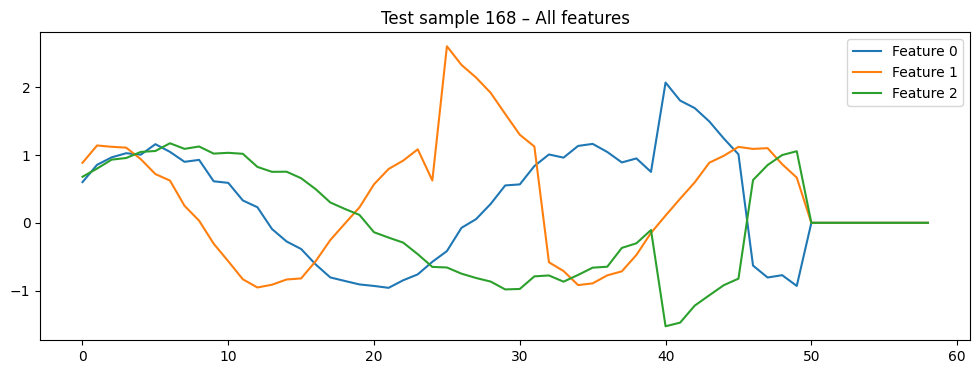

In [23]:
plt.figure(figsize=(12, 4))
for f in range(x_test.shape[2]):
    plt.plot(x_test[idx, :, f], label=f"Feature {f}")
plt.legend()
plt.title("Test sample {} – All features".format(idx))
plt.show()

I don't blame the model for not finding all 3 defects here, because 2 of them on orange line appear at the same time.

## Description of model
This model processes time-series data using two LSTM layers (64 and 32 units) to capture temporal patterns and outputs defect probabilities through a Dense layer with 5 sigmoid nodes, enabling multi-label classification. It is optimized with Adam and binary cross-entropy loss, making it well-suited for identifying multiple defects simultaneously.

# Explainability of defects

Our idea is too create RNN autoencoder that will simplify given candy's time series into simpler basic one that does not contain extreme outliares, ergo no defects. Then we take candies where only one defect was found and we compare their graph to no-defect one calculated by autoencoder and their most apparent difference is probably the reason for the given defect.

## RNN autoencoder

We are definig LSTM autoencoder that compresses an input time series into a fixed-length latent representation using an encoder LSTM, then reconstructs the full sequence by repeating this latent vector across time and decoding it with a second LSTM followed by a per-timestep linear projection to the original feature space.

In [24]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, latent_dim=64):
        super().__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=latent_dim,
            batch_first=True
        )

        # Decoder
        self.decoder = nn.LSTM(
            input_size=latent_dim,
            hidden_size=latent_dim,
            batch_first=True
        )

        # TimeDistributed(Dense(features)) from keras translated into pytorch
        # https://stackoverflow.com/questions/47305618/what-is-the-role-of-timedistributed-layer-in-keras 
        self.output_layer = nn.Linear(latent_dim, n_features)

    def forward(self, x):
        
        # Encode
        _, (h, _) = self.encoder(x)        # h: (1, batch, latent_dim)
        h = h.squeeze(0)                   # (batch, latent_dim)

        # RepeatVector
        h_repeat = h.unsqueeze(1).repeat(1, self.seq_len, 1)
        # (batch, seq_len, latent_dim)

        # Decode
        decoded, _ = self.decoder(h_repeat)

        # TimeDistributed Dense
        output = self.output_layer(decoded)

        return output


We are creating RNN Autoencoder for our problem. We are also making sure that we will be using cuda (I don't want to wait longer then it's neccesary). We will be using Mean Square Error loss function, because it's often picked for autoencoders. I will be using Adam optimizer (with parameters to match Keras Adam defaults, it works better that way), because I use it most often and it's overall good.

In [25]:
autoencoder = LSTMAutoencoder(seqLen, featNum).to(device)
print(next(autoencoder.parameters()).device)
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(
    autoencoder.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-7
)

cuda:0


## Training autoencoder

I already did that, but if you want to retrain it yourself just change `retrain_autoencoder` variable to `True` and rerun the code.

In [26]:
xl_padded_ae = xl_padded[yl_tensor.sum(dim=1) == 0]
yl_tensor_ae = yl_tensor[yl_tensor.sum(dim=1) == 0]
no_defect_loader = DataLoader(
    TensorDataset(xl_padded_ae, yl_tensor_ae),
    batch_size=batch_size,
    shuffle=True
)

In [27]:
epochs = 500 #we want to overfit as much as possible the whole autoencoder to the no-defect data

retrain_autoencoder = False

if retrain_autoencoder:
    train_losses = []

    for epoch in range(epochs):
        autoencoder.train()
        epoch_loss = 0

        for xb, _ in no_defect_loader:
            xb = xb.to(device)

            optimizer.zero_grad()
            recon = autoencoder(xb)
            loss = criterion(recon, xb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(no_defect_loader)
        train_losses.append(epoch_loss)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")
    torch.save(autoencoder.state_dict(), "lstm_autoencoder.pt")

We can see how training loss was changing.

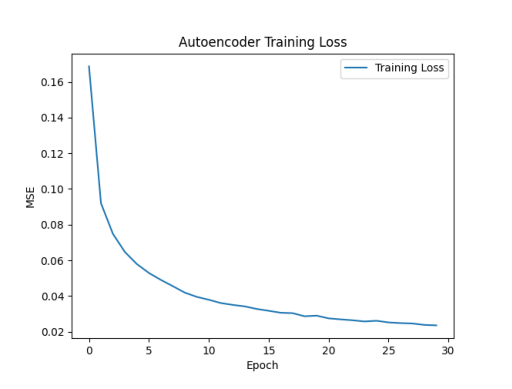

In [28]:
if retrain_autoencoder:
    plt.figure()
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Autoencoder Training Loss")
    plt.savefig("autoencoder_loss.png")
    plt.show()
else:
    from PIL import Image
    img = Image.open("autoencoder_loss.png")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Since model was already trained let's load it from the file.

In [29]:
autoencoder.load_state_dict(torch.load("lstm_autoencoder.pt"))
autoencoder.eval()
with torch.no_grad():
    recon = autoencoder(x_test.to(device)).cpu()

C:\Users\pawel\AppData\Local\Temp\ipykernel_17412\2208028217.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("lstm_autoencoder.pt"

## Find graph differences for each defect

We will be using squared distance as an error and then compare it to the treshold. Tested many thresholds manually - 0.19 performed well. This measures difference between reconstructed (estimatted) data and original.

In [30]:
threshold = 0.19

For each defect we will find `n` = 3 candies with this defect alone, unless we will give `n` as parameter.

In [31]:
# k is no. of defect we would like to test
def candy_for_defects(k, n):
    candies = []
    defect = [0.]*y_test[0].shape[0]
    if k<0: # if k is negative number we generate candy ids without defects
        for i in range(5, y_test.shape[0]):
            if y_test[i].sum() == 0:
                candies.append(i)
            if len(candies) >= n:
                break
        return candies
    defect[k]=1.
    defect = torch.tensor(defect)
    for i in range(y_test.shape[0]):
        if y_test[i].sum() == 1:
            if str(y_test[i]) == str(defect):
                candies.append(i)
        if len(candies) >= n:
            break
    return candies

In [32]:
def get_anomalies(idx):
    original = x_test[idx][1:xl[len(x_train) + len(x_val) + idx].shape[0]-1]
    defects = y_test[idx]
    reconstructed = recon[idx][1:xl[len(x_train) + len(x_val) + idx].shape[0]-1]
    errors = (original - reconstructed) ** 2
    anomalies = errors > threshold
    return original, defects, reconstructed, errors, anomalies

In [33]:
col = ['#1f77b4', '#ff7f0e', '#2ca02c']
def visualize_candy_defects(k=0,n=3):
    candy_indices = candy_for_defects(k,n)
    for idx in candy_indices:
        print(f"Visualizing candy index: {len(x_train) + len(x_val) + idx}")
        original, defects, reconstructed, errors, anomalies = get_anomalies(idx)
        print("Defects in this sample:", defects.numpy())
        plt.figure(figsize=(4, 1))
        plt.plot(original)
        plt.title("Original Candy no. {} Time Series".format(len(x_train) + len(x_val) + idx))
        plt.show()
        
        plt.figure(figsize=(15, 6))

        for i in range(original.shape[1]):
            plt.subplot(original.shape[1], 1, i + 1)
            plt.plot(original[:, i], label="Original", color=col[i])
            plt.plot(reconstructed[:, i], label="Reconstructed", color="black")
            plt.plot(
                np.where(anomalies[:, i], original[:, i], np.nan),
                "ro",
                label="Anomaly",
                zorder=10
            )
            anom = np.asarray(anomalies)
            anomaly_indices = np.where(anom[:, i])[0]
            if anomaly_indices.size > 0:
                if anomaly_indices.size == 1:
                    center = int(anomaly_indices[0])
                    left = max(0, center - 1)
                    right = min(original.shape[0] - 1, center + 1)
                else:
                    
                    left = int(anomaly_indices.min())
                    right = int(anomaly_indices.max())
                plt.axvspan(
                    left,
                    right,
                    facecolor="red",
                    alpha=0.15,
                    edgecolor="none",
                    linewidth=0,
                    zorder=0
                )
                
            plt.title(f"Feature {i}")
            plt.legend()

        plt.tight_layout()
        plt.show()
        print("\n\n")

#### Defect for [1,0,0,0,0]

Visualizing candy index: 45012
Defects in this sample: [1. 0. 0. 0. 0.]


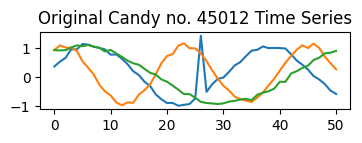

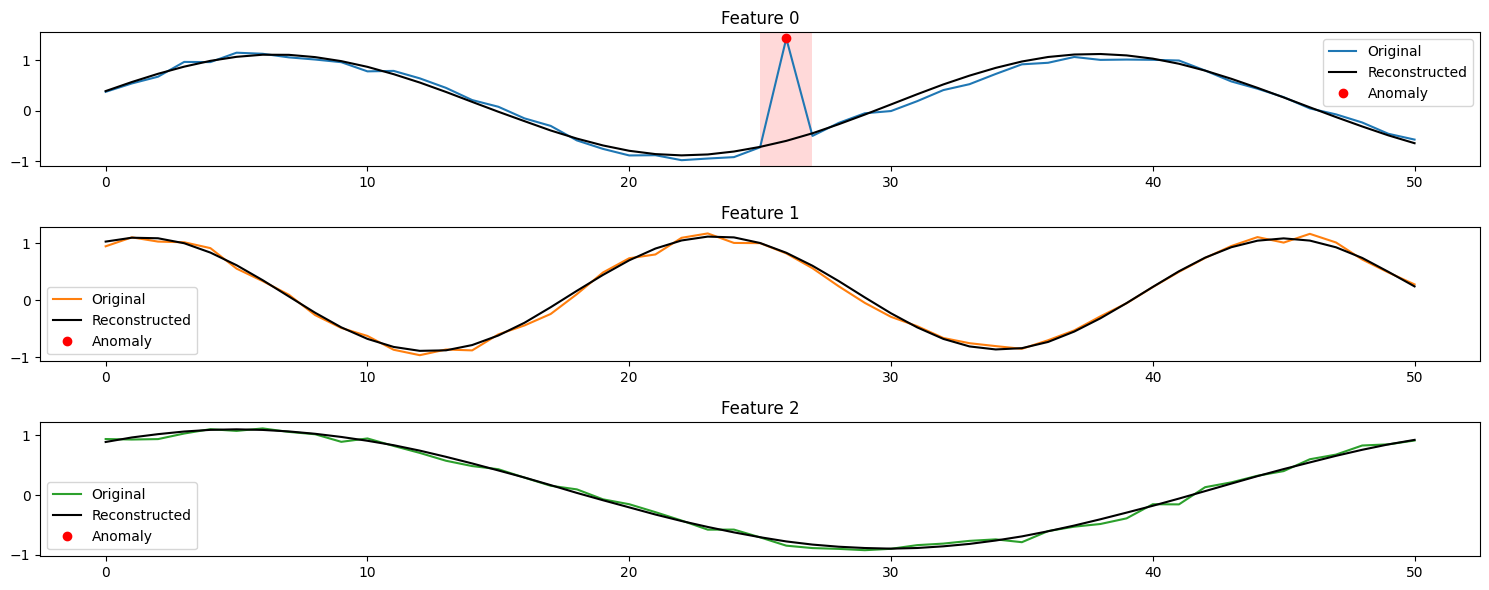




Visualizing candy index: 45015
Defects in this sample: [1. 0. 0. 0. 0.]


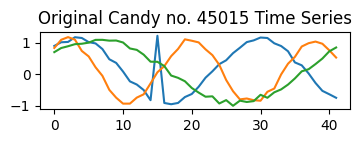

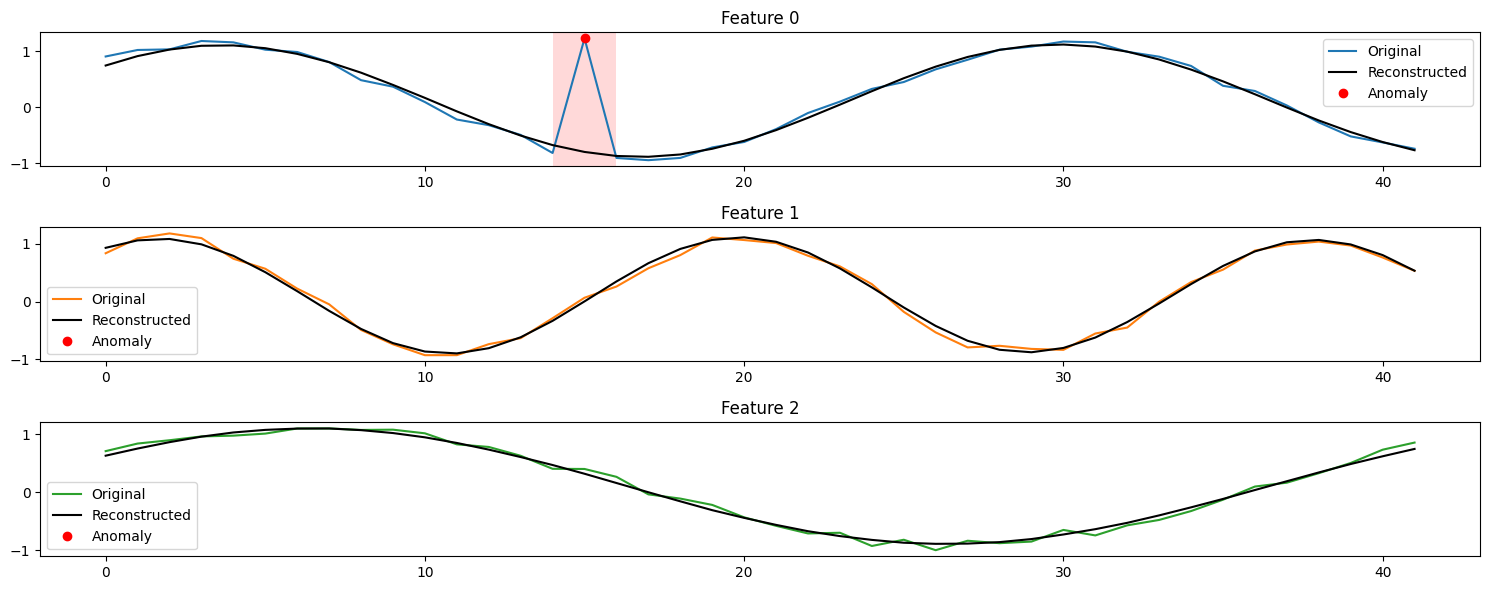




Visualizing candy index: 45048
Defects in this sample: [1. 0. 0. 0. 0.]


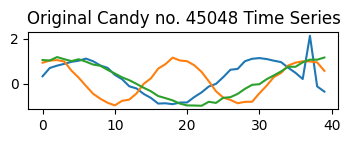

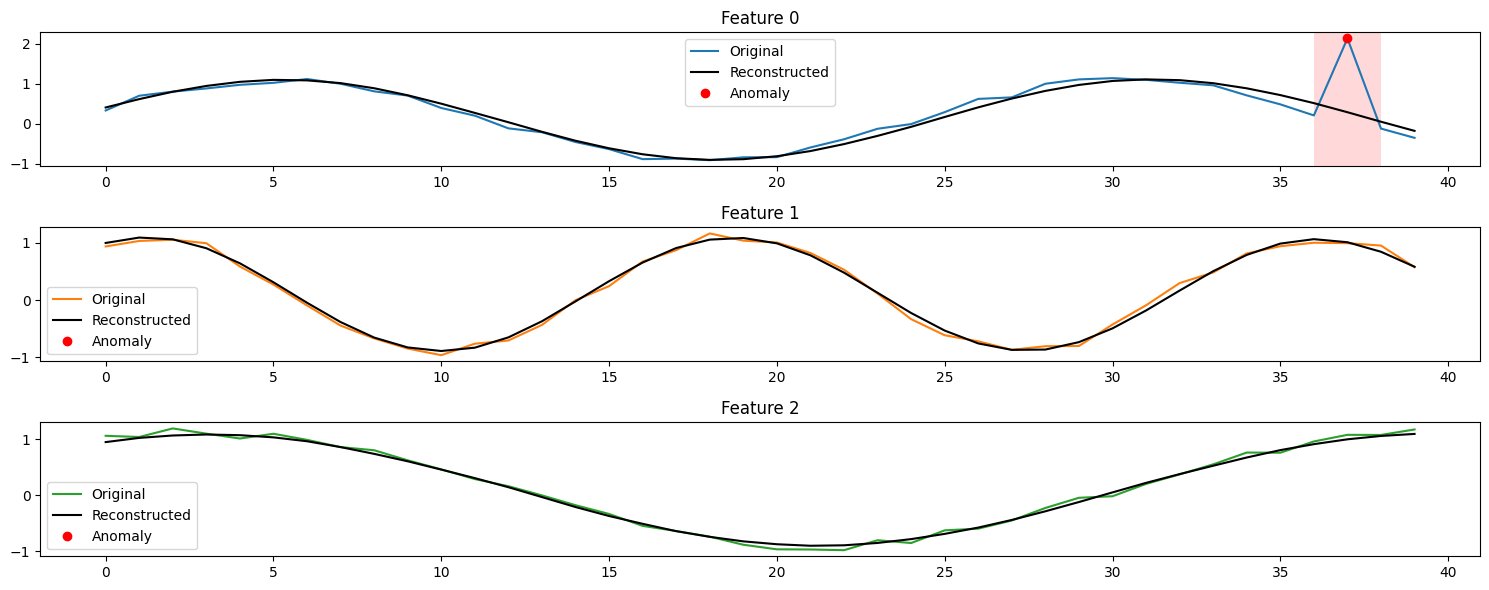

In [34]:
visualize_candy_defects(0)

Now we can clearly see that defect number 1 is just sudden spike in the blue feature of candy making process. 

#### Defect for [0,1,0,0,0]

Visualizing candy index: 45008
Defects in this sample: [0. 1. 0. 0. 0.]


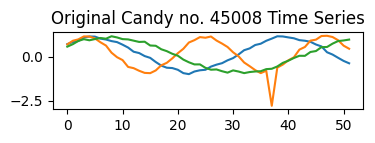

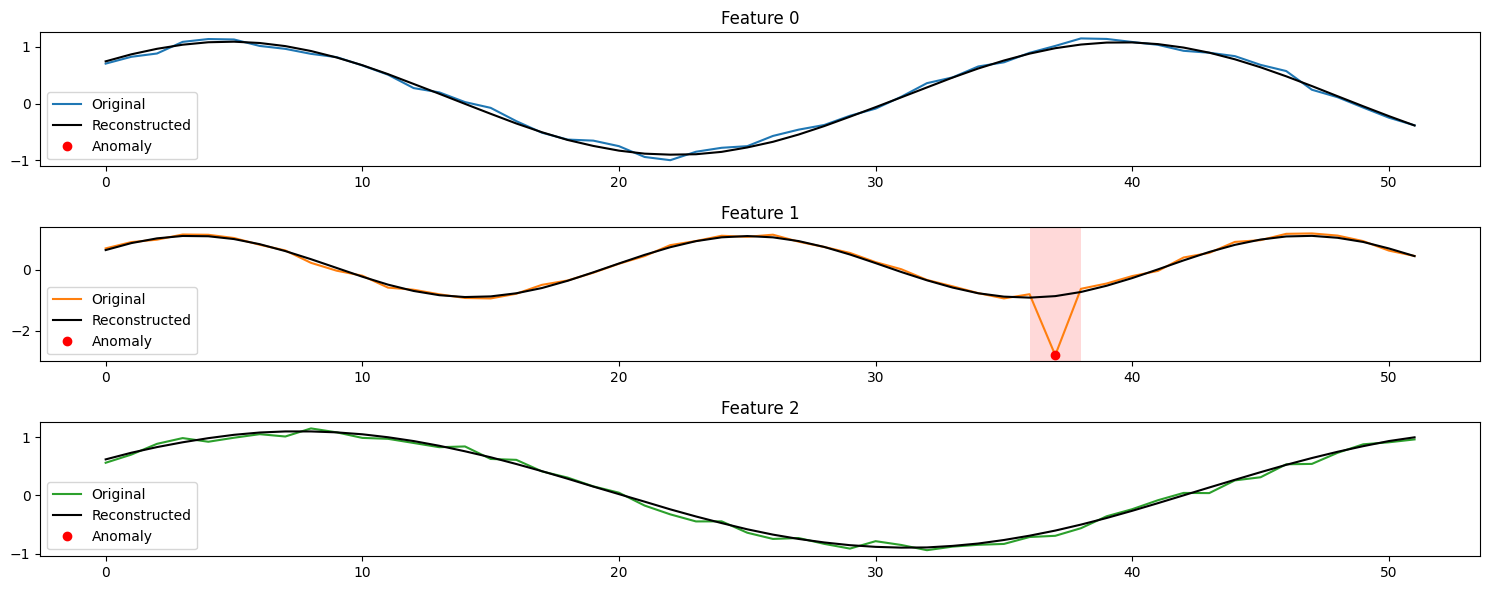




Visualizing candy index: 45023
Defects in this sample: [0. 1. 0. 0. 0.]


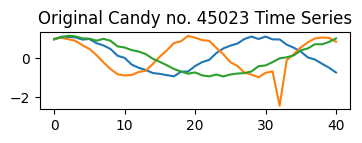

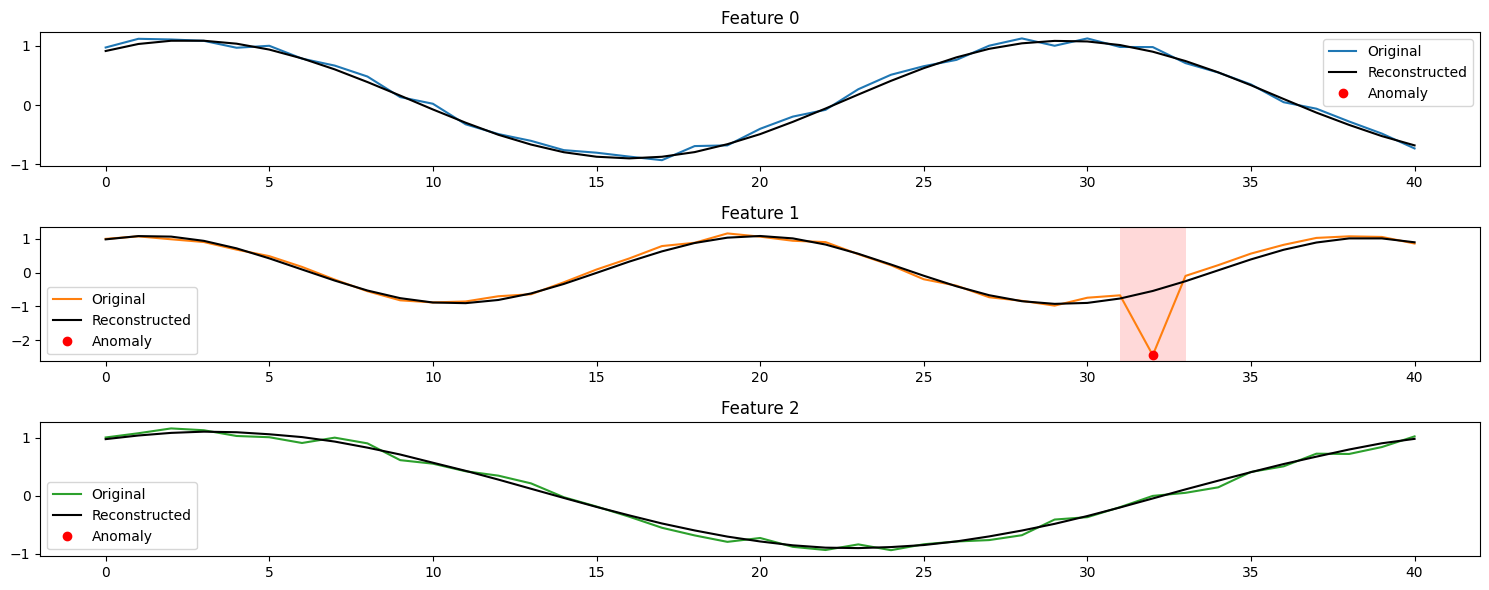




Visualizing candy index: 45026
Defects in this sample: [0. 1. 0. 0. 0.]


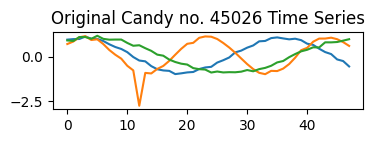

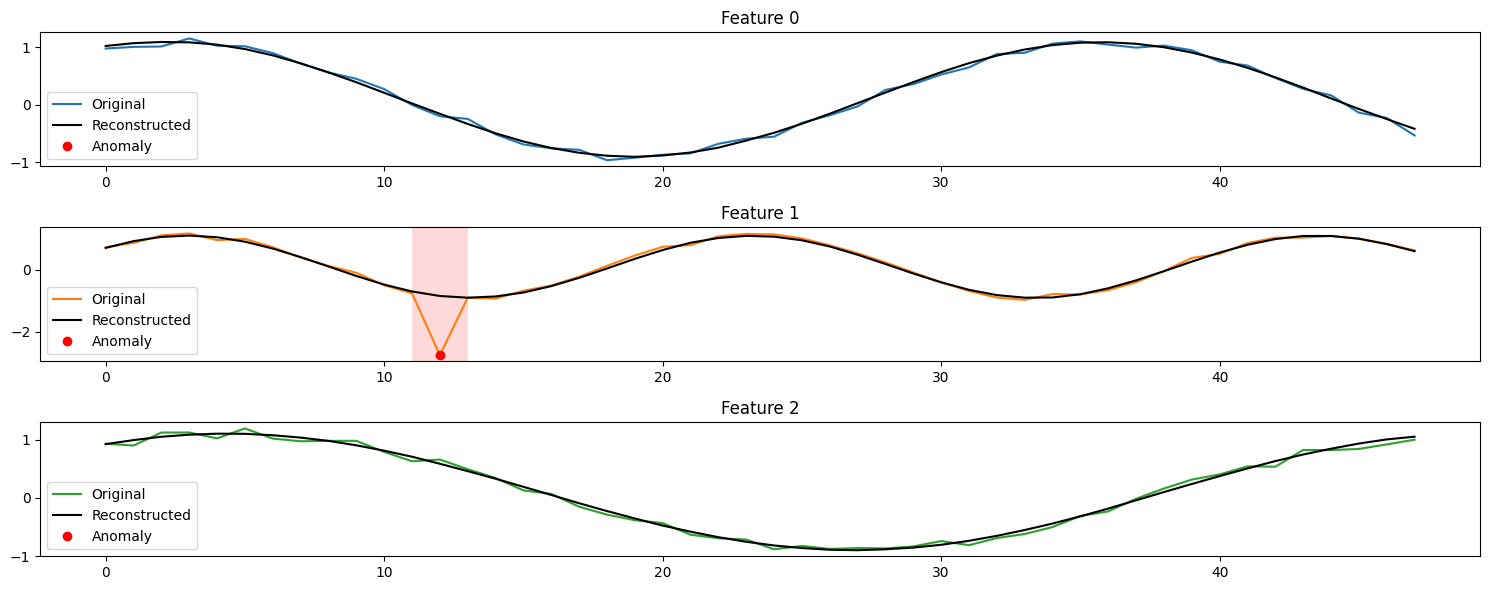

In [35]:
visualize_candy_defects(1)

Now we can clearly see that defect number 2 is just sudden drop in the orange feature of candy making process. 

#### Defect for [0,0,1,0,0]

Visualizing candy index: 45049
Defects in this sample: [0. 0. 1. 0. 0.]


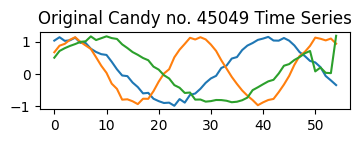

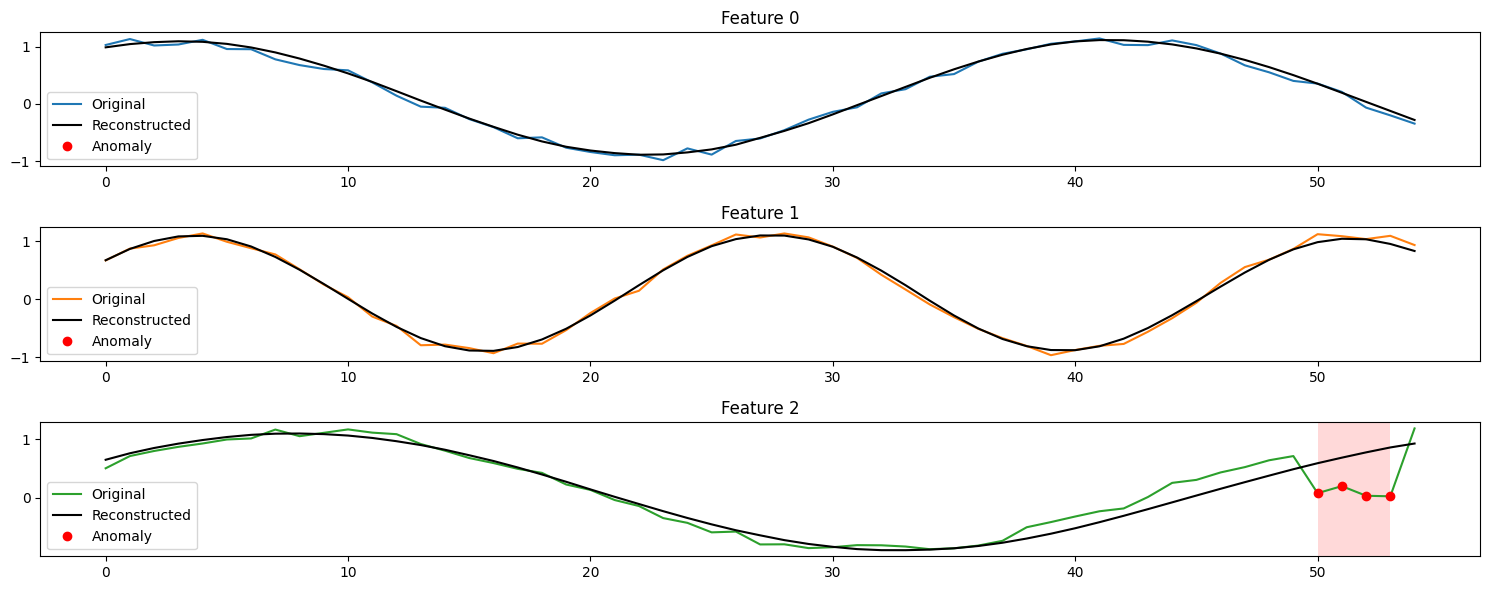




Visualizing candy index: 45054
Defects in this sample: [0. 0. 1. 0. 0.]


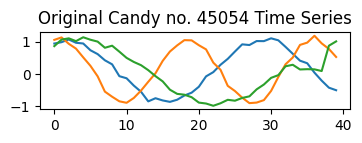

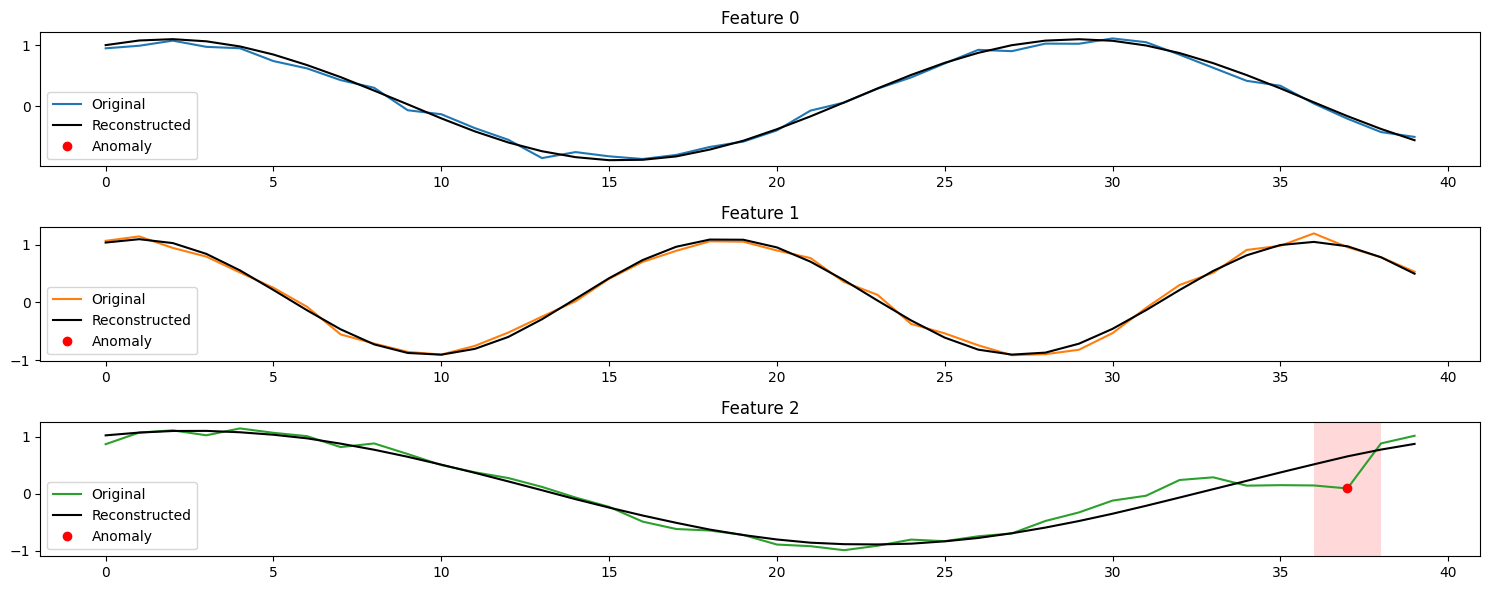




Visualizing candy index: 45057
Defects in this sample: [0. 0. 1. 0. 0.]


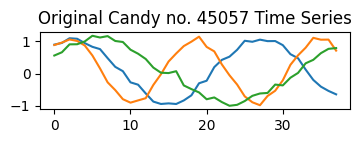

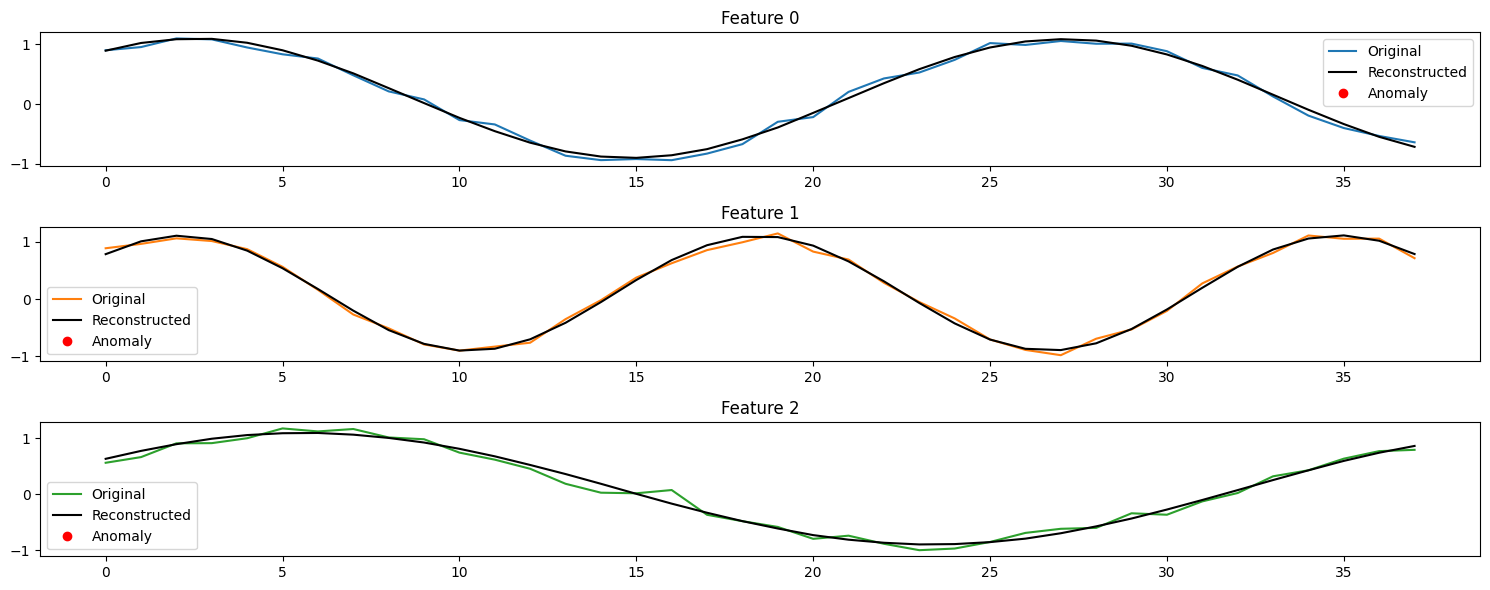




Visualizing candy index: 45073
Defects in this sample: [0. 0. 1. 0. 0.]


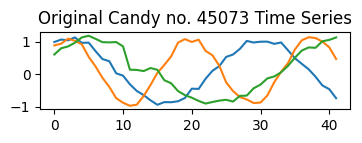

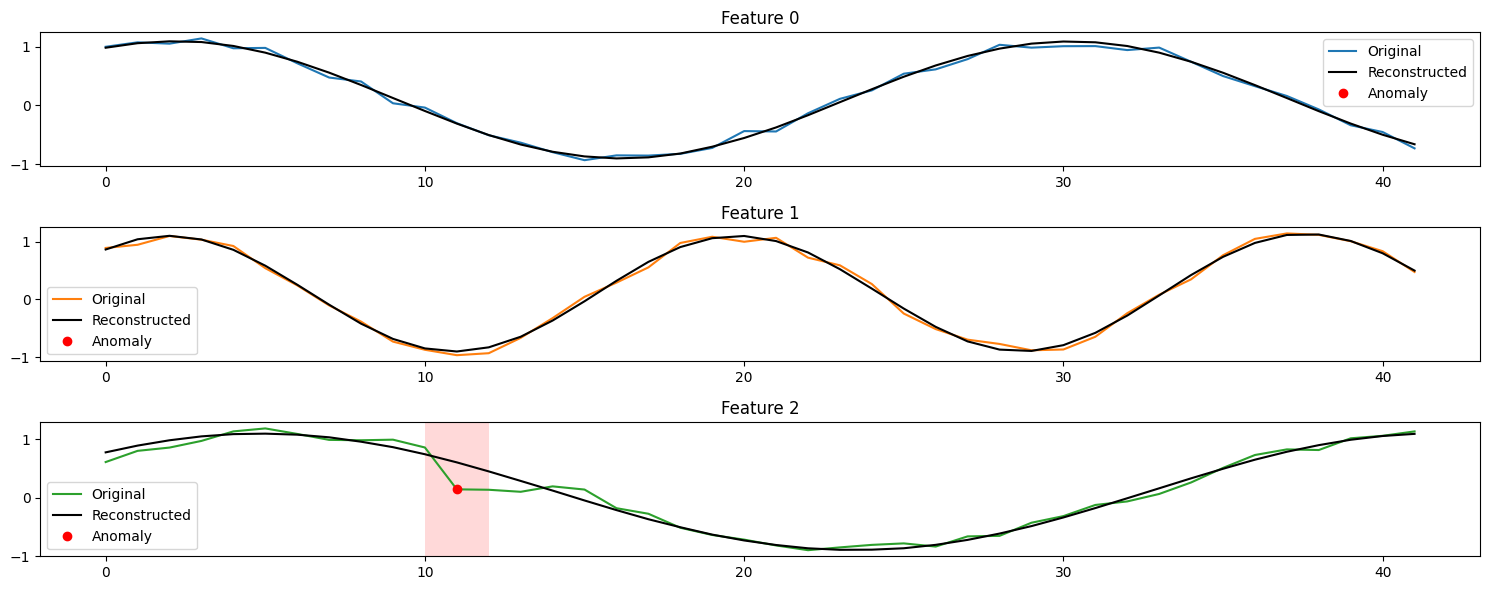




Visualizing candy index: 45099
Defects in this sample: [0. 0. 1. 0. 0.]


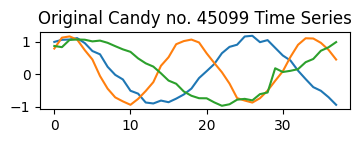

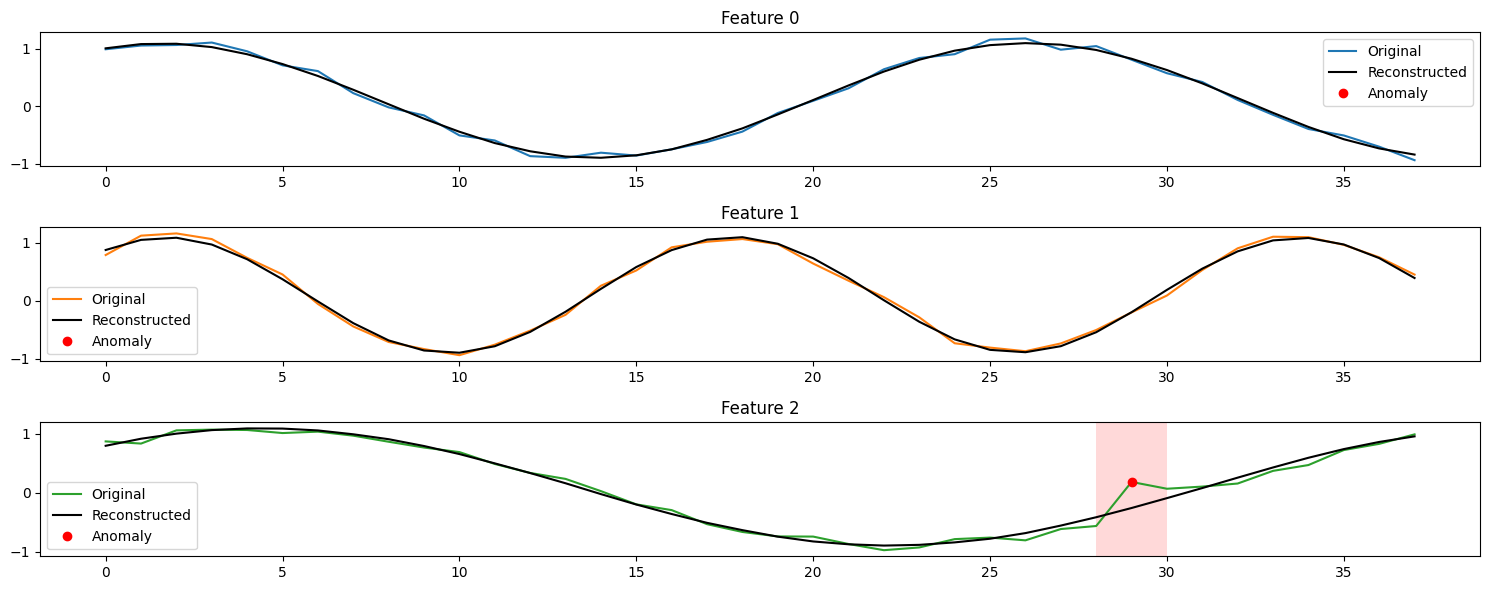

In [36]:
visualize_candy_defects(2, 5)

Now we can somehow see that defect number 3. Marked feauture is sometimes above and sometimes below expected value in the green feature of candy making process. Someone with more trained eye can see that original graph is bent in the direction of 0. After some thinking we can conclude that this feauture is just sudden zero-value interval. It's especially hard to detect in times when green feature value should be 0 anyways, like in "candy no. 45057" example.

#### Defect for [0,0,0,1,0]

Visualizing candy index: 45005
Defects in this sample: [0. 0. 0. 1. 0.]


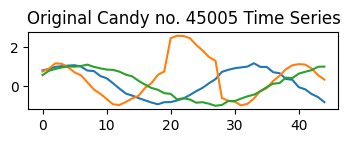

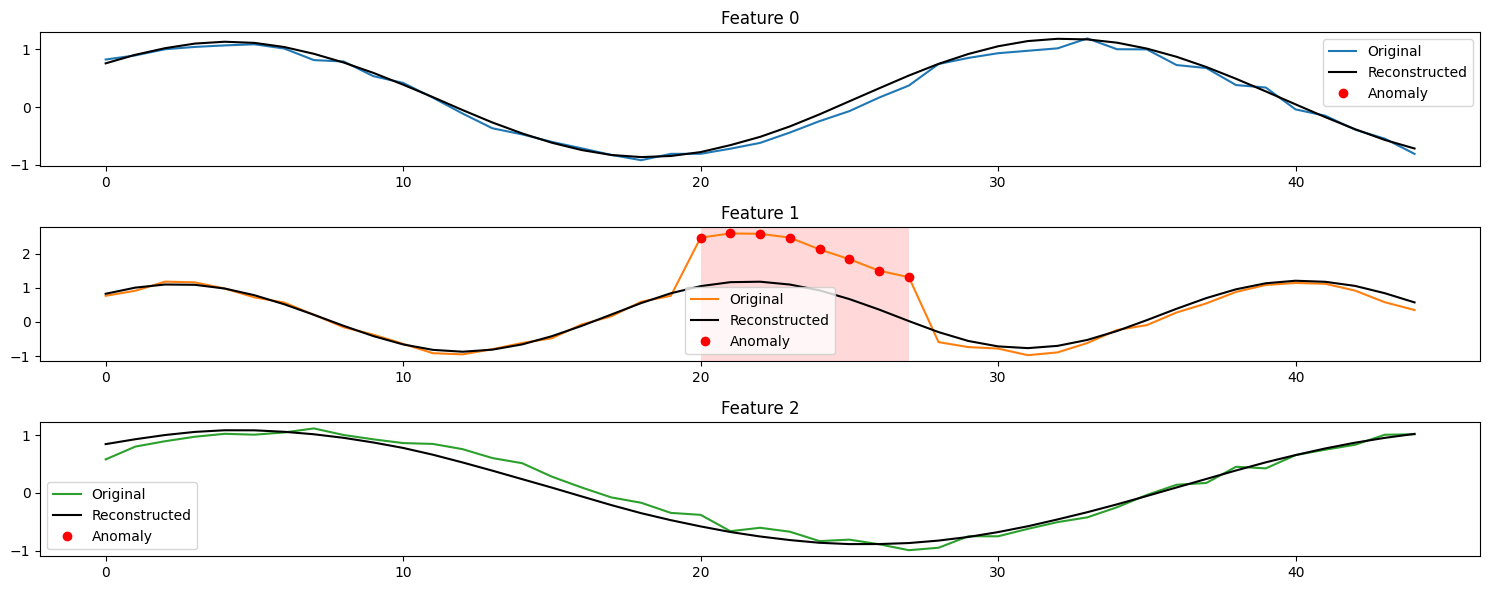




Visualizing candy index: 45014
Defects in this sample: [0. 0. 0. 1. 0.]


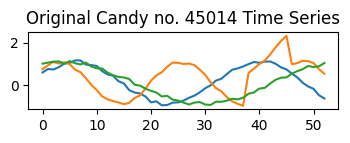

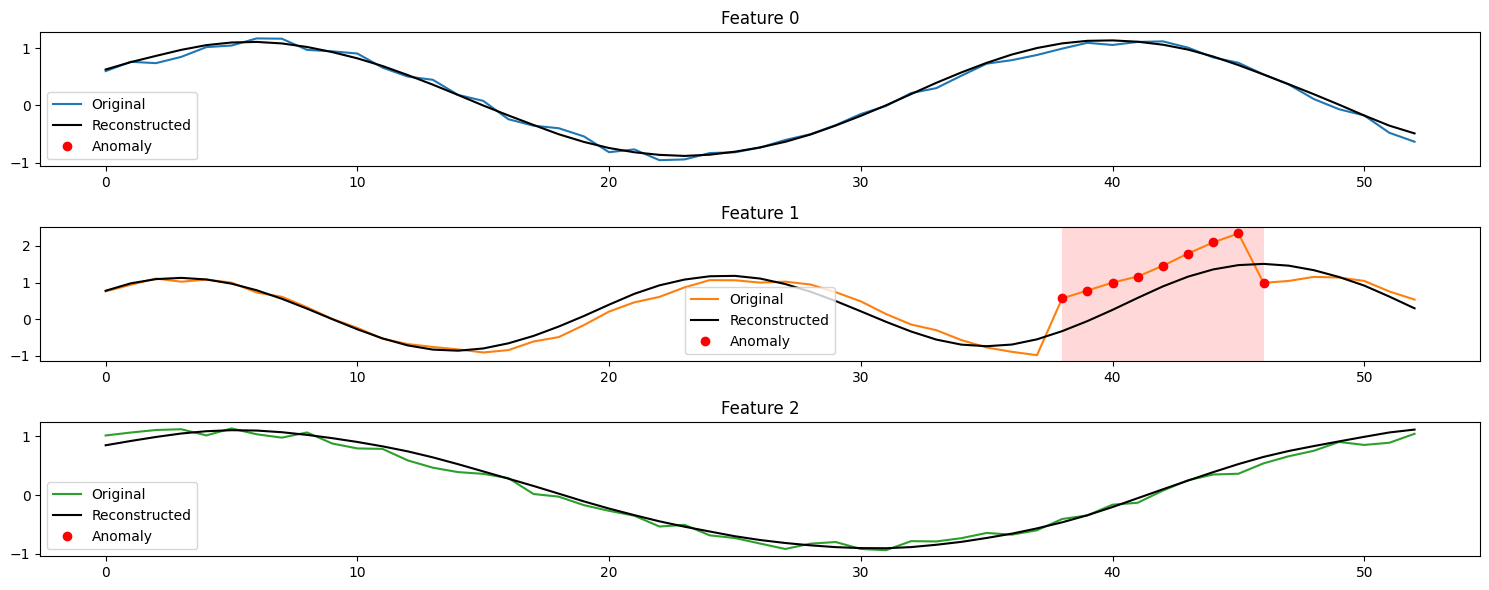




Visualizing candy index: 45024
Defects in this sample: [0. 0. 0. 1. 0.]


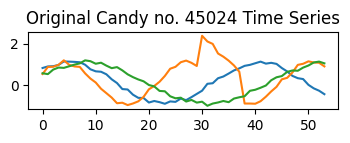

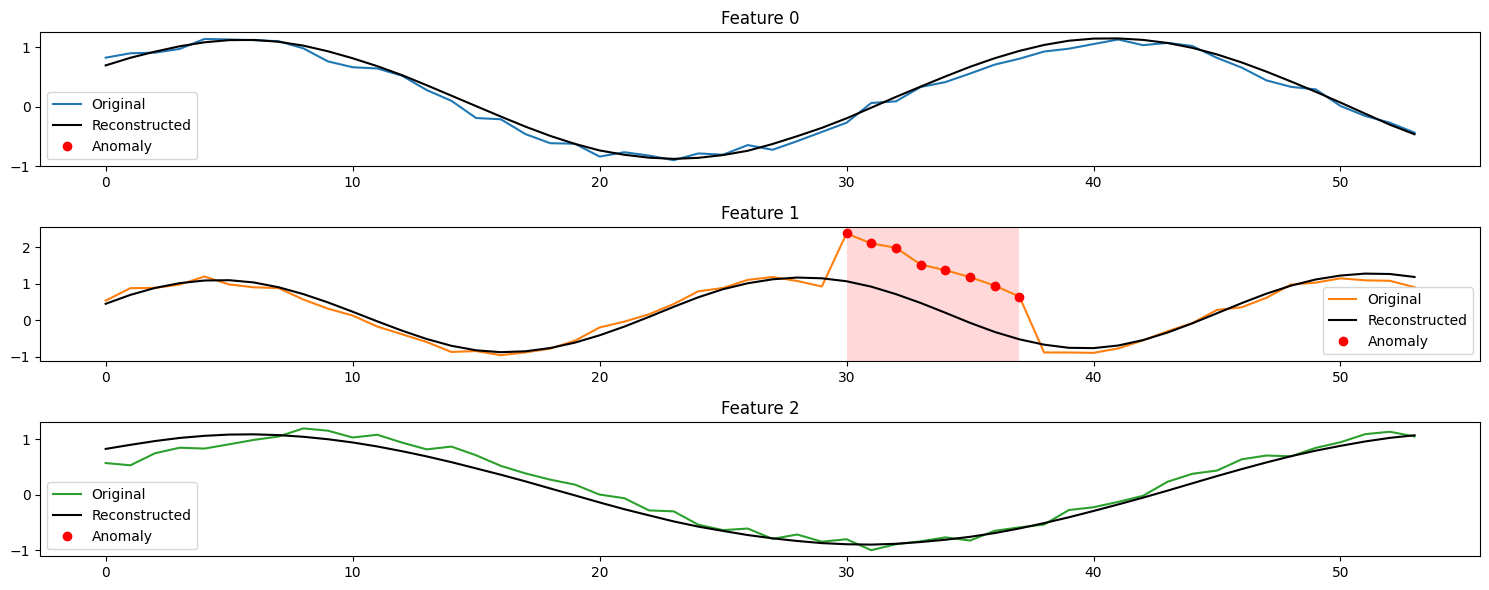

In [37]:
visualize_candy_defects(3)

Now we can clearly see that defect number 4 is just longer lasting increase of value, that creates buldge on graph, in the orange feature of candy making process. 

#### Defect for [0,0,0,0,1]

Visualizing candy index: 45002
Defects in this sample: [0. 0. 0. 0. 1.]


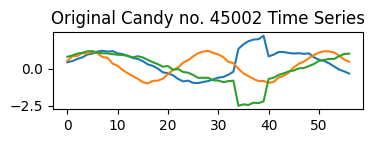

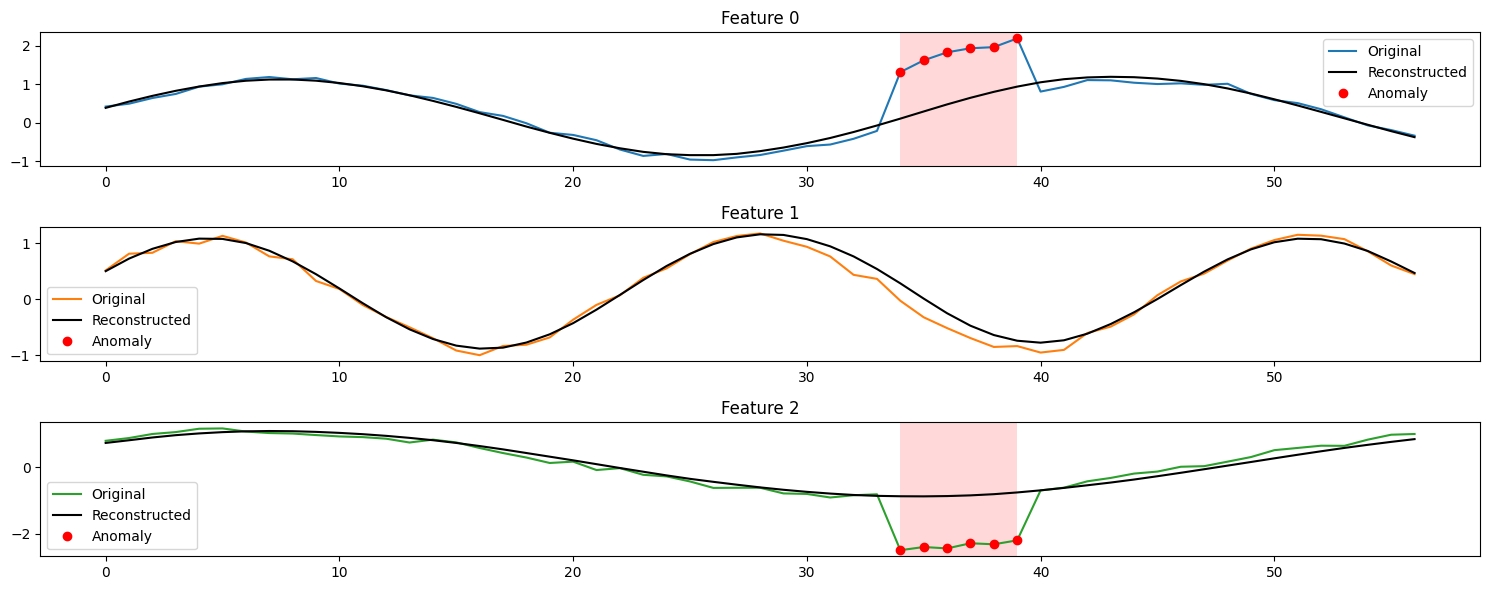




Visualizing candy index: 45040
Defects in this sample: [0. 0. 0. 0. 1.]


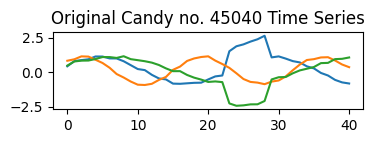

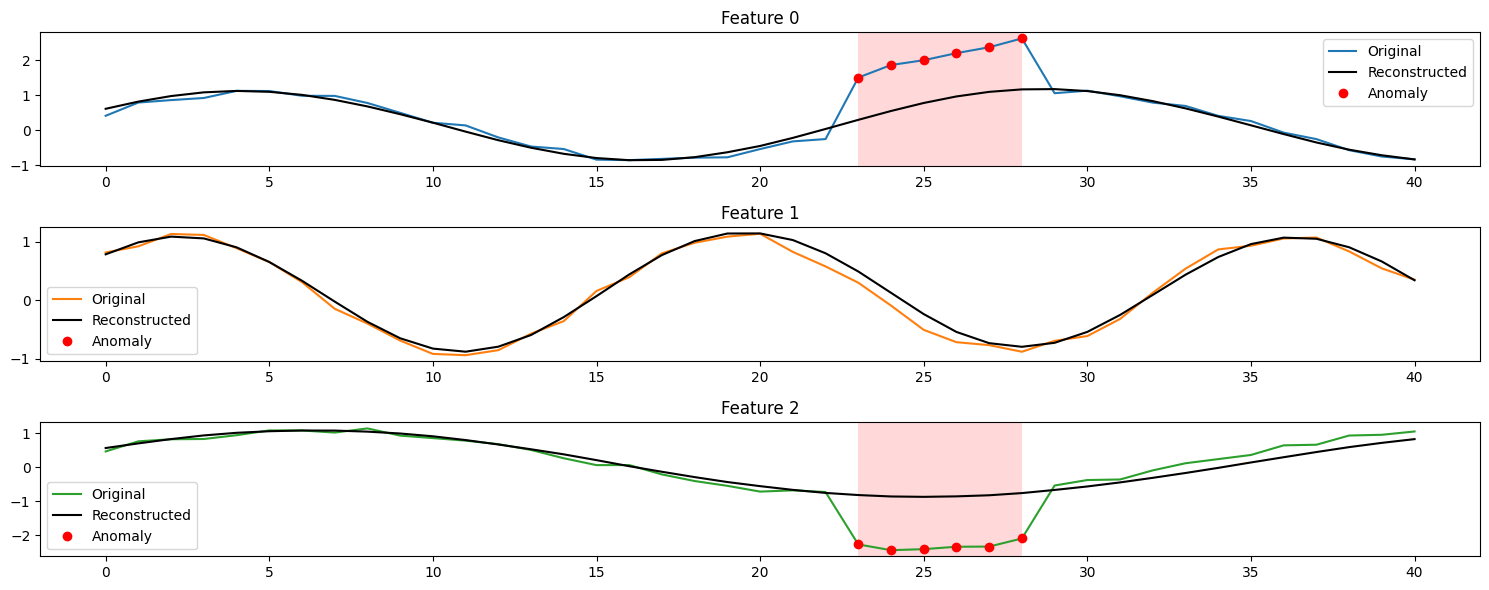




Visualizing candy index: 45042
Defects in this sample: [0. 0. 0. 0. 1.]


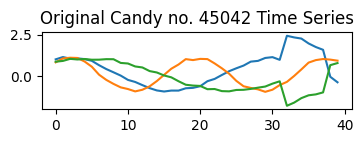

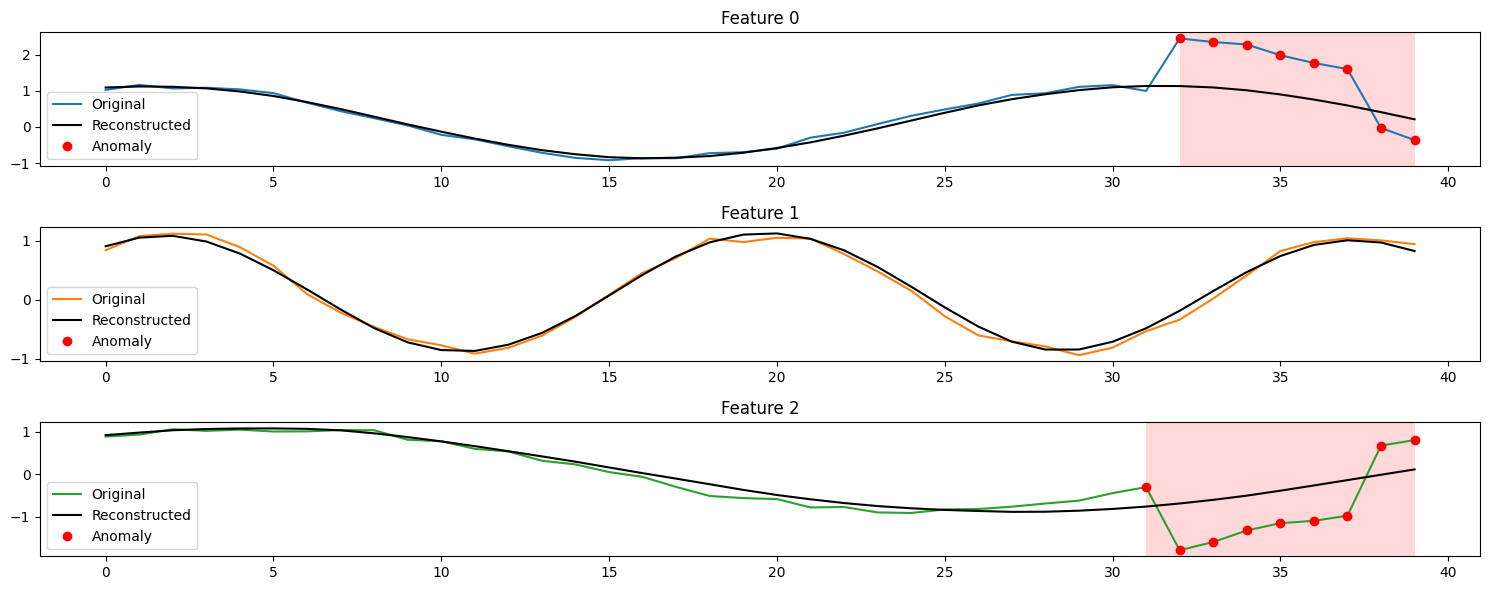

In [38]:
visualize_candy_defects(4)

Now we can clearly see that defect number 5 is more complex: it's appearing at the same time increase of value, that creates buldge on graph, in the blue feature and decrease of value, that creates valley on graph, in the green feature of candy making process. 

#### No defects

Visualizing candy index: 45013
Defects in this sample: [0. 0. 0. 0. 0.]


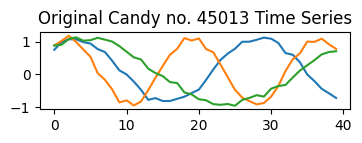

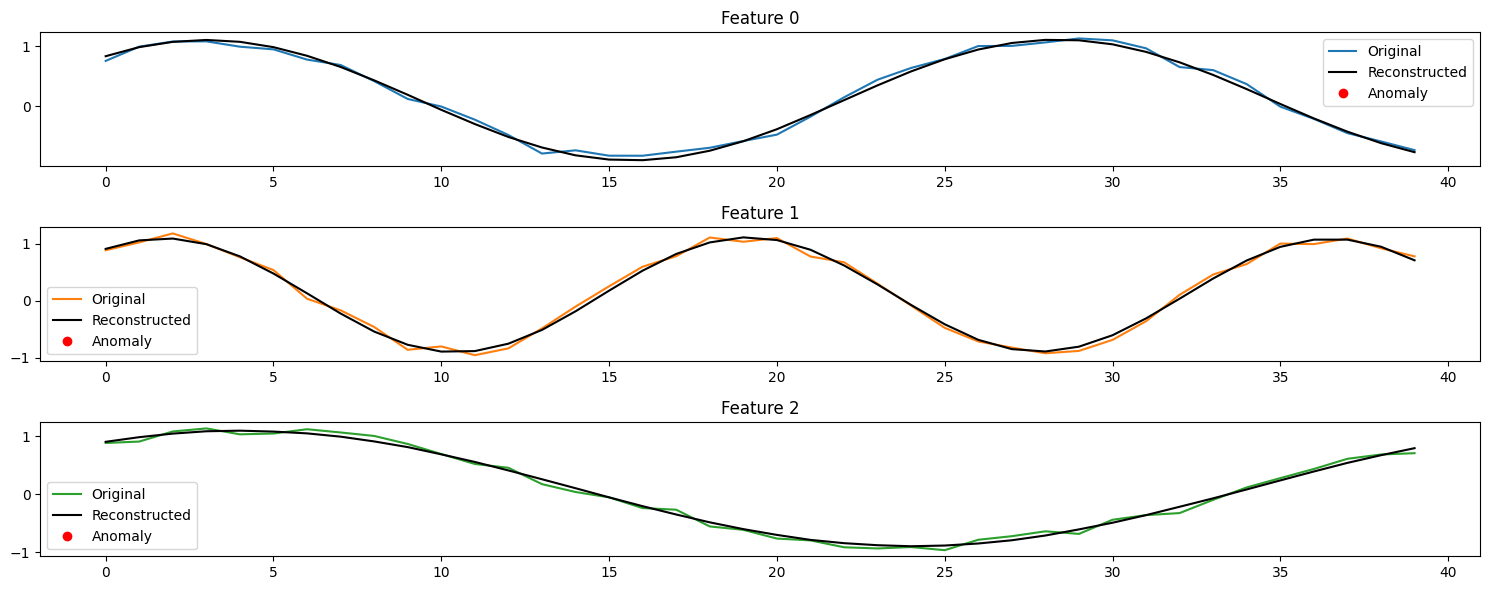




Visualizing candy index: 45020
Defects in this sample: [0. 0. 0. 0. 0.]


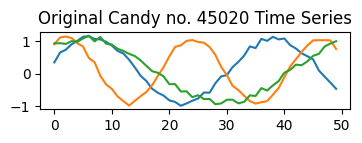

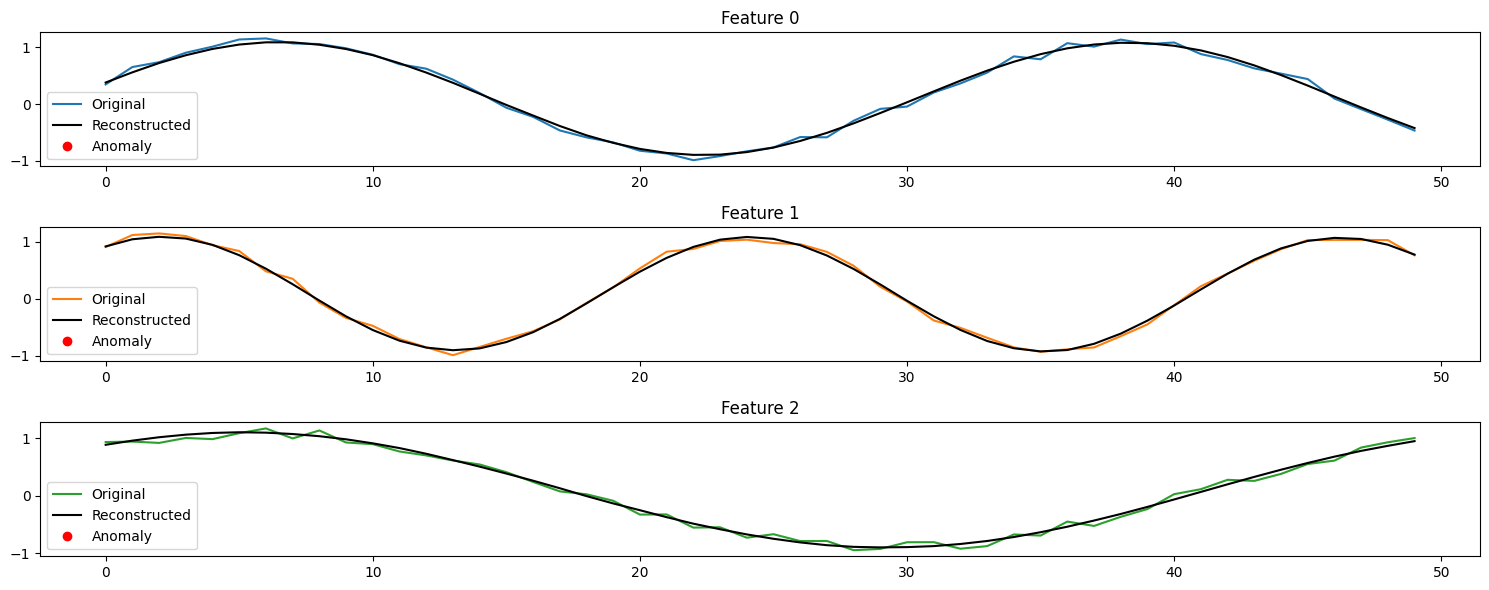




Visualizing candy index: 45025
Defects in this sample: [0. 0. 0. 0. 0.]


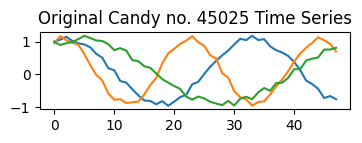

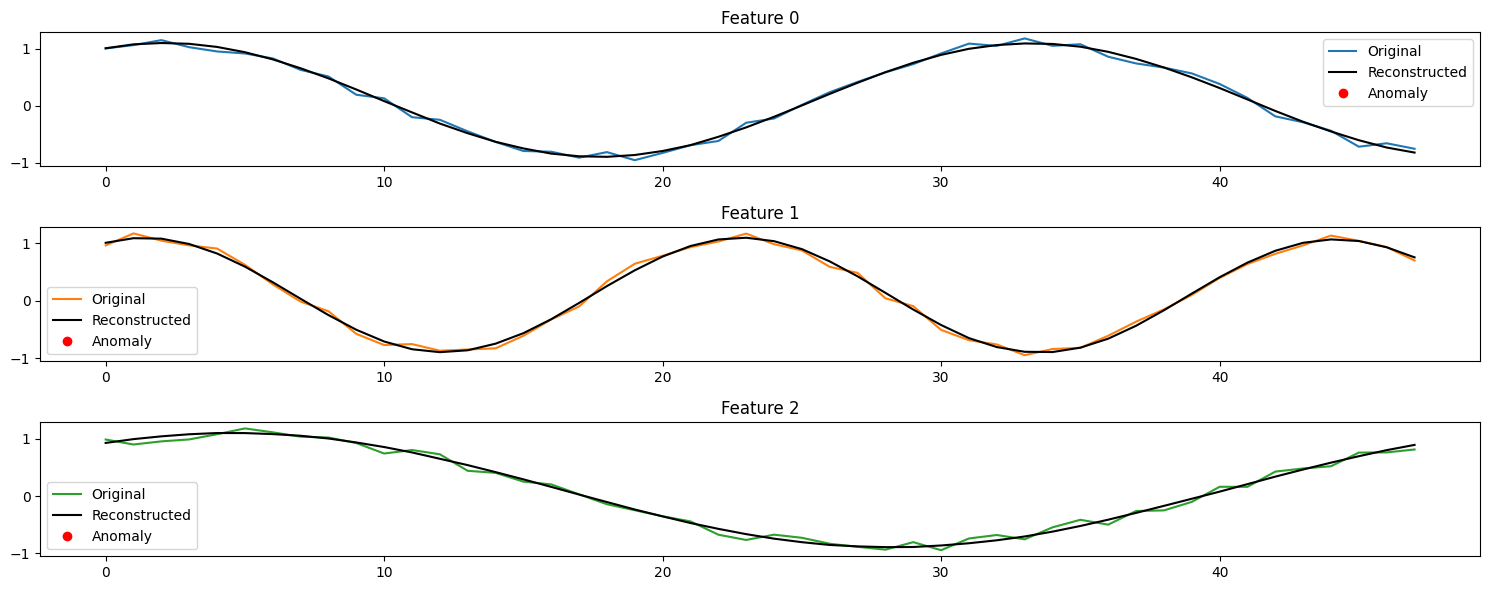

In [39]:
visualize_candy_defects(-1)

No defects - nothing abnormal was detected by autoencoder.

#### Multiple random defects

In [40]:
def cluster_anomalies(i, anomalies, gap_threshold=4):
    anom = np.asarray(anomalies)
    anomaly_indices = np.where(anom[:, i])[0]

    if anomaly_indices.size > 0:
        # sort just in case
        anomaly_indices = np.sort(anomaly_indices)
        # split into clusters
        clusters = [[anomaly_indices[0]]]
        for idx_curr in anomaly_indices[1:]:
            if idx_curr - clusters[-1][-1] > gap_threshold:
                clusters.append([idx_curr])
            else:
                clusters[-1].append(idx_curr)
        return clusters
    else:
        return []

Visualizing candy index: 45034
Defects in this sample: [1. 1. 1. 1. 0.]


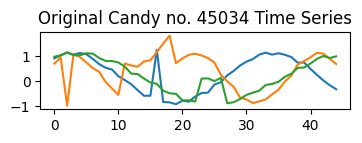

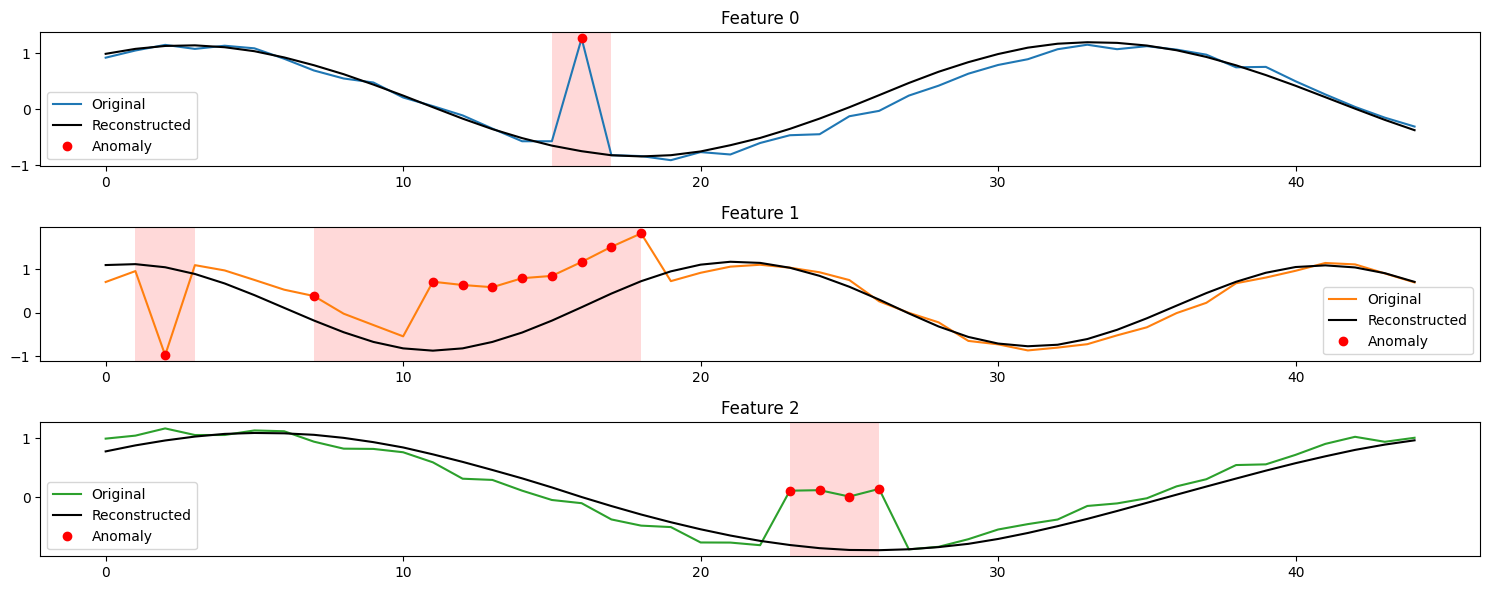

In [41]:
multiclass_indices = np.where(y_test.sum(axis=1) > 3)[0]
idx = multiclass_indices[1]
print(f"Visualizing candy index: {len(x_train) + len(x_val) + idx}")
original, defects, reconstructed, errors, anomalies = get_anomalies(idx)
print("Defects in this sample:", defects.numpy())
plt.figure(figsize=(4, 1))
plt.plot(original)
plt.title("Original Candy no. {} Time Series".format(len(x_train) + len(x_val) + idx))
plt.show()

plt.figure(figsize=(15, 6))

for i in range(original.shape[1]):
    plt.subplot(original.shape[1], 1, i + 1)
    plt.plot(original[:, i], label="Original", color=col[i])
    plt.plot(reconstructed[:, i], label="Reconstructed", color="black")
    plt.plot(
        np.where(anomalies[:, i], original[:, i], np.nan),
        "ro",
        label="Anomaly",
        zorder=10
    )
    clusters = cluster_anomalies(i, anomalies)
    
    # draw one rectangle per cluster
    for cluster in clusters:
        if len(cluster) == 1:
            center = cluster[0]
            left = max(0, center - 1)
            right = min(original.shape[0] - 1, center + 1)
        else:
            left = cluster[0]
            right = cluster[-1]

        plt.axvspan(
            left,
            right,
            facecolor="red",
            alpha=0.15,
            edgecolor="none",
            linewidth=0,
            zorder=0
        )

        
    plt.title(f"Feature {i}")
    plt.legend()

plt.tight_layout()
plt.show()

We found all 4 defects! But which anomaly is coresponding to which defect?

# Which witch is which

The idea is for us to leave only one cluster of anomalies in the time series and replace the rest of them with autoencoder reconstruction. Then we will run our RNN classifier on this time series with just one anomaly and check which defect number is the most propable cause for it. We will repeat this for all anomaly clusters we have.  

In [42]:
def analyze_anomalies(idx):
    original, defects, reconstructed, errors, anomalies = get_anomalies(idx)
    where = []
    preds = []
    for i in range(original.shape[1]):
        clusters = cluster_anomalies(i, anomalies)
        for cluster in clusters:
            new_series1 = original.clone() # one time series with anomaly in given feature only 
            new_series2 = original.clone() # second time series with anomaly in all features (for defect no. 5 related to a pattern occurring at two sensors simultaneously)
            for j in range(original.shape[0]):
                if j not in cluster:
                    new_series1[j] = reconstructed[j]
                    new_series2[j] = reconstructed[j]
                    
                else:
                    new_series1[j] = reconstructed[j]
                    new_series1[j, i] = original[j, i]
                    new_series2[j] = original[j]
                    
            new_series1 = new_series1.unsqueeze(0).to(device)  # add batch dimension
            new_series2 = new_series2.unsqueeze(0).to(device)  # add batch dimension
            with torch.no_grad():
                pred1 = model(new_series1).cpu().numpy()[0]
                pred2 = model(new_series2).cpu().numpy()[0]
            
            pred2_bin = (pred2 > 0.95).astype(int)
            if pred2_bin.sum() > 1: # if more than one defect is predicted in second variant of time series it means that this time series is ambiguous and we should trust the first variant more
                pred = pred1
            else:
                pred = pred2
            where.append((cluster, i))
            preds.append(pred)
    return where, preds


where, preds = analyze_anomalies(idx)
for (cluster, i), pred in zip(where, preds):
    print(f"Anomaly cluster {cluster} from feature {i}: Predicted defect probabilities: {pred}. The most probable defect: {np.argmax(pred)}")

Anomaly cluster [np.int64(16)] from feature 0: Predicted defect probabilities: [9.9989378e-01 1.8683438e-04 2.7347804e-04 3.1777739e-04 2.3301141e-04]. The most probable defect: 0
Anomaly cluster [np.int64(2)] from feature 1: Predicted defect probabilities: [9.1642758e-04 9.9982601e-01 7.3673844e-04 2.1840131e-04 7.9868885e-05]. The most probable defect: 1
Anomaly cluster [np.int64(7), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)] from feature 1: Predicted defect probabilities: [6.0096034e-04 4.4504827e-04 1.2618455e-03 9.9996996e-01 7.8008161e-05]. The most probable defect: 3
Anomaly cluster [np.int64(23), np.int64(24), np.int64(25), np.int64(26)] from feature 2: Predicted defect probabilities: [6.3879526e-04 5.7662028e-04 9.9918813e-01 1.3863402e-04 1.2298695e-04]. The most probable defect: 2


Now we know which defect came from which anomaly in time series. Let's visualize it.

## Visualization

Visualizing candy index: 45034
Defects in this sample: [1. 1. 1. 1. 0.]


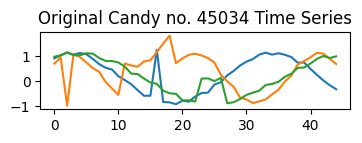

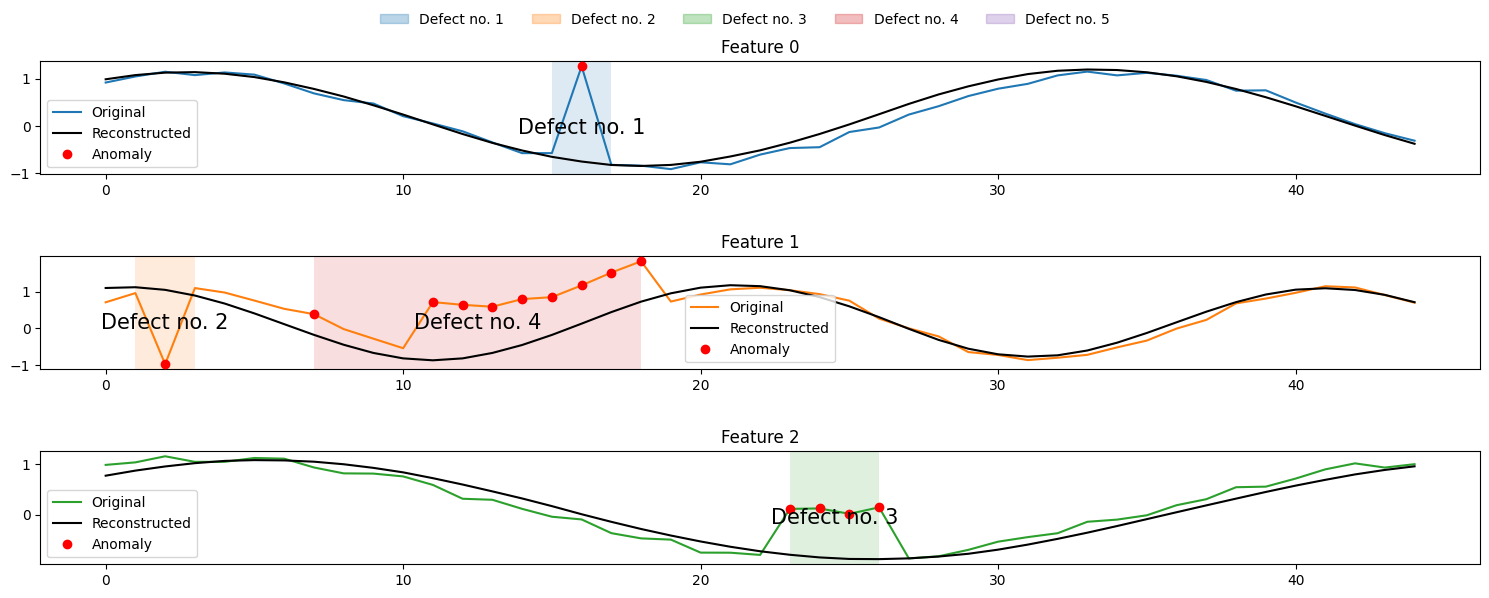

In [43]:
import matplotlib.patches as mpatches
color_map = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
class_labels = [f"Defect no. {i+1}" for i in range(len(color_map))]
color_legend_handles = [
    mpatches.Patch(color=color_map[i], alpha=0.3, label=class_labels[i])
    for i in range(len(color_map))
]
def visualize_many(idx):
    print(f"Visualizing candy index: {len(x_train) + len(x_val) + idx}")
    original, defects, reconstructed, errors, anomalies = get_anomalies(idx)
    where, preds = analyze_anomalies(idx)
    print("Defects in this sample:", defects.numpy())
    plt.figure(figsize=(4, 1))
    plt.plot(original)
    plt.title("Original Candy no. {} Time Series".format(len(x_train) + len(x_val) + idx))
    plt.show()

    plt.figure(figsize=(15, 6))

    for i in range(original.shape[1]):
        plt.subplot(original.shape[1], 1, i + 1)
        plt.plot(original[:, i], label="Original", color=col[i])
        plt.plot(reconstructed[:, i], label="Reconstructed", color="black")
        plt.plot(
            np.where(anomalies[:, i], original[:, i], np.nan),
            "ro",
            label="Anomaly",
            zorder=10
        )
        for (cluster, feat_idx), pred in zip(where, preds):
            if feat_idx == i:         
                if len(cluster) == 1:
                    center = cluster[0]
                    left = max(0, center - 1)
                    right = min(original.shape[0] - 1, center + 1)
                else:
                    left = cluster[0]
                    right = cluster[-1]
                label = np.argmax(pred)
                plt.axvspan(
                    left,
                    right,
                    facecolor=color_map[label],
                    alpha=0.15,
                    edgecolor="none",
                    linewidth=0,
                    zorder=0
                )
                
                x_center = (left + right) / 2
                y_pos = 0.5

                plt.text(
                    x_center,
                    y_pos,
                    class_labels[label],
                    ha="center",
                    va="top",
                    transform=plt.gca().get_xaxis_transform(),  # x=data, y=axes
                    fontsize=15,
                    color="black",
                    zorder=50
                )

            
        plt.title(f"\nFeature {i}")
        plt.legend()

    fig = plt.gcf()
    fig.legend(
        color_legend_handles,
        class_labels,
        loc="upper center",
        ncol=len(color_map),
        frameon=False
    )
    plt.tight_layout()
    plt.show()

idx = multiclass_indices[1]
visualize_many(idx)

It works! Let's check on other examples.

Visualizing candy index: 45069
Defects in this sample: [1. 1. 1. 0. 1.]


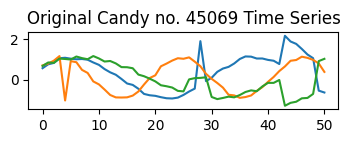

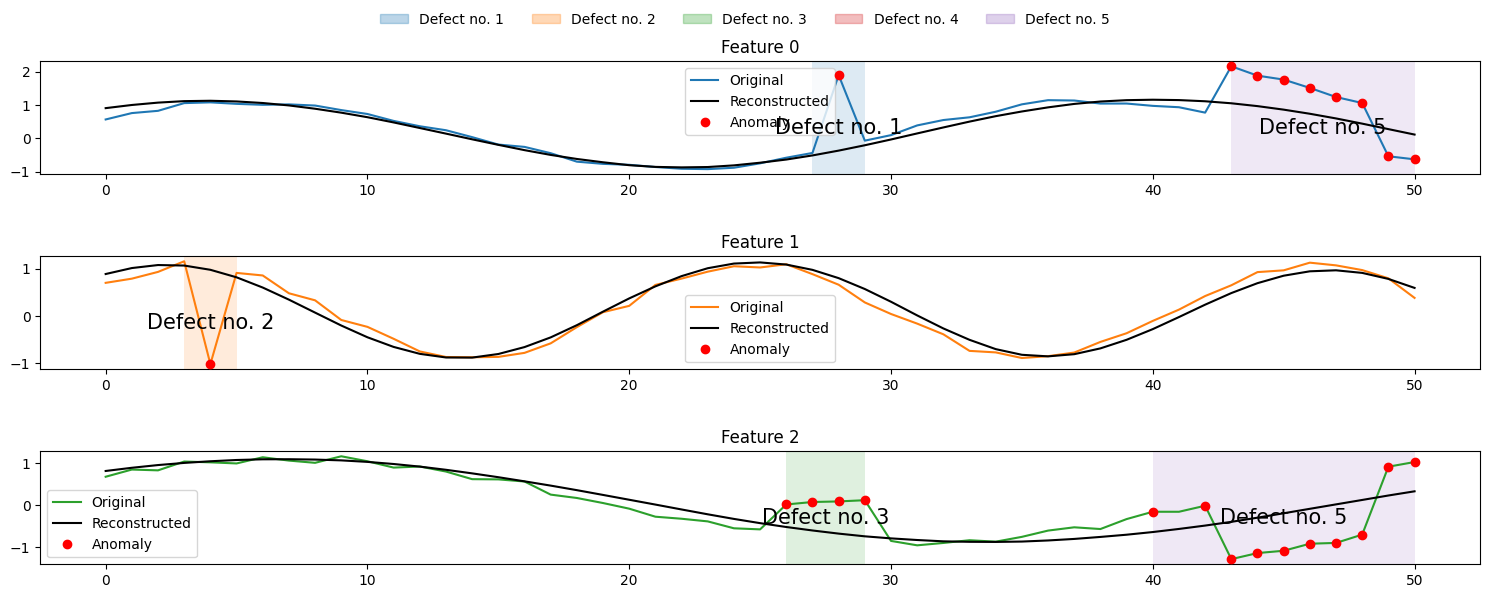

In [44]:
idx = multiclass_indices[2]
visualize_many(idx)

Visualizing candy index: 45336
Defects in this sample: [1. 1. 1. 0. 1.]


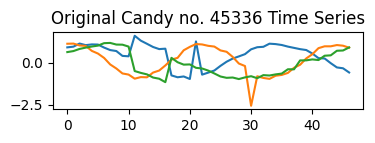

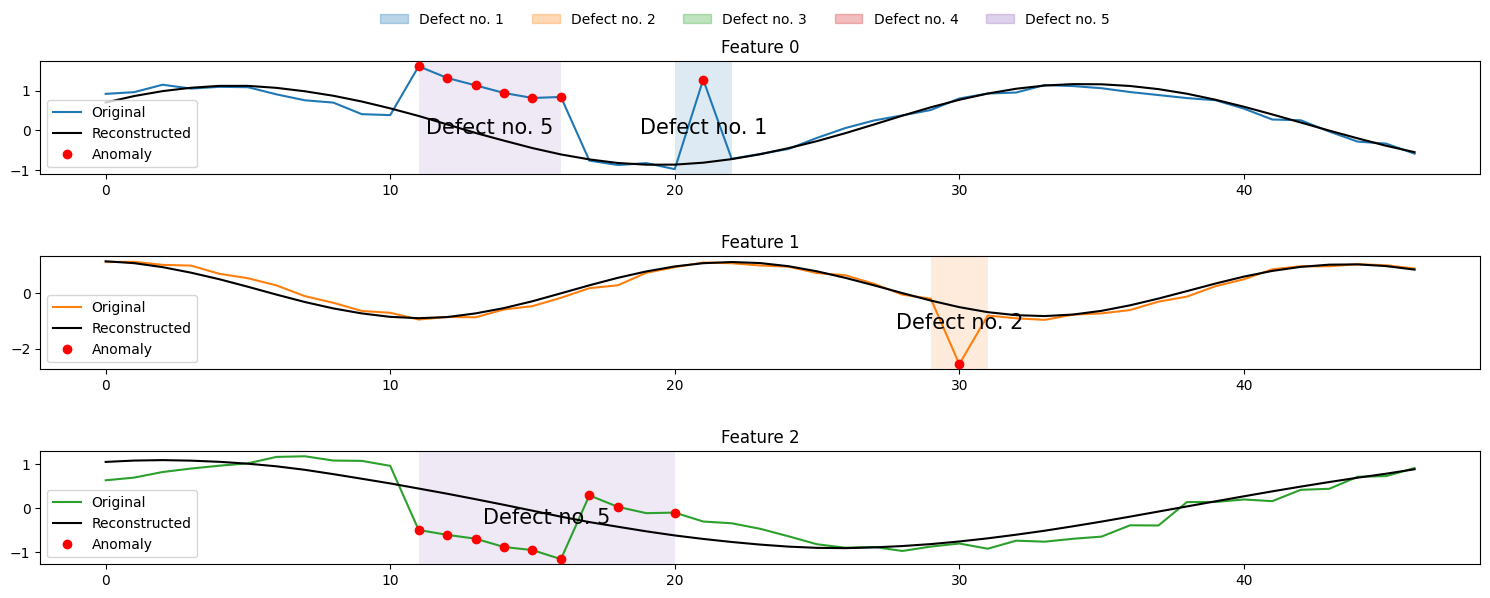

In [45]:
idx = multiclass_indices[3]
visualize_many(idx)

Visualizing candy index: 45505
Defects in this sample: [1. 0. 1. 1. 1.]


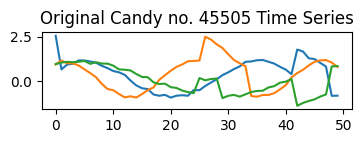

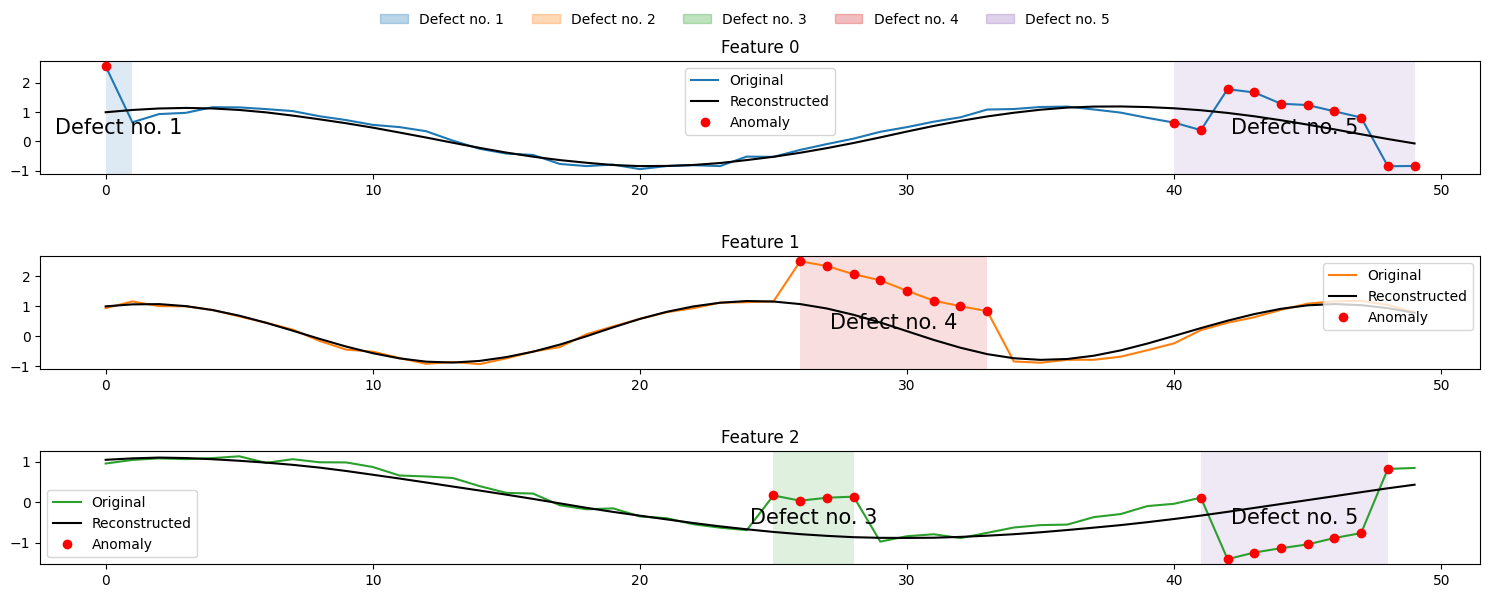

In [46]:
idx = multiclass_indices[4]
visualize_many(idx)

# Summary

Our approach worked beautifully. We got nice high accuracy on our prediction model of 99.832%. We also were able to perfectly pinpoint which feauture of candy making timeseries is responsible for which candy defect, even the complex multi-feautured defect number 5. I consider this project as absolute success!🍬🍬🍬

# Contributors
- Wiktor Bocheński 160215 as random number generator for examples